In [44]:
import pandas as pd

In [45]:
df = pd.read_csv('after_EDA.csv')
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [46]:
# df.dtypes

# df.columns

# def print_unique_col_values(df):
#     for col in df:
#         if df[col].dtype == 'object':
#             unique_values = df[col].unique()
#             print(f"Unique values in column '{col}({len(unique_values)})': {unique_values}")

# print_unique_col_values(df)

# df.replace('No internet service','No',inplace=True)
# df.replace('No phone service','No',inplace=True)

# print_unique_col_values(df)


# yes_no_cols = [col for col in df if df[col].dtype == 'object' and set(df[col].unique()) == {'Yes', 'No'}]
# yes_no_cols

# # ordinal encoding for 'binary' columns (manulally by replacing values)
# # converting 'Yes' to 1 and 'No' to 0
# # converting 'Female' to 1 and 'Male' to 0

# for col in yes_no_cols:
#     df[col].replace({'Yes': 1, 'No': 0}, inplace=True)

# df['gender'].replace({'Female': 1, 'Male':0}, inplace=True)

# for col in df:
#     print(f'{col} : {df[col].unique()}')

**Instead of converting category to number manually it is better to do with Onehotencoding. Because:**

- It prevents data leakage
- Add more dynamicity
- Can handle unseen category type (OHE(handle_unkown=True))

In [47]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [48]:
# %pip install scikit-learn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                test_size=0.2, stratify=y, random_state=42)

In [49]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

In [50]:
print("Unique values in y_train:", y_train.unique())
print("Data type of y_train:", y_train.dtype)

Unique values in y_train: ['No' 'Yes']
Data type of y_train: object


In [51]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

y_train = y_train.map({'Yes': 1, 'No': 0}).astype('float32')
y_test = y_test.map({'Yes': 1, 'No': 0}).astype('float32')

In [52]:
print("After conversion - Unique values in y_train:", y_train.unique())
print("After conversion - Unique values in y_test:", y_test.unique())


After conversion - Unique values in y_train: [0. 1.]
After conversion - Unique values in y_test: [0. 1.]


**Preparing data for pytorch model below**

In [53]:
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

In [54]:
import torch
X_train_tensor = torch.FloatTensor(X_train_processed)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_processed)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)


## Model Architecture

In [55]:
import torch.nn as nn
import torch.optim as optim

class ChurnPredictionModel(nn.Module):
    
    def __init__(self, input_dim, hidden_units=64):
        super().__init__()
        self.network = nn.Sequential(
            #layer 1
            nn.Linear(in_features=input_dim, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            #layer 2
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            #layer 3
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            #layer 4
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            #layer 5
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            #Output layer
            nn.Linear(in_features=hidden_units, out_features=1),
            nn.Sigmoid()  # as binary classification
        )

    def forward(self, x):
        return self.network(x)


In [56]:
# initializing the model

model = ChurnPredictionModel(X_train_processed.shape[1])
criterion = nn.BCELoss()  # Binary cross entropy loss
optimizer = optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)


Starting training...
Epoch   0 | Train Loss: 0.7037 | Val AUC: 0.4894 | best_val_auc: 0.4894 | patience_counter: 0
Epoch   1 | Train Loss: 0.7028 | Val AUC: 0.4894 | best_val_auc: 0.4894 | patience_counter: 0
Epoch   2 | Train Loss: 0.7013 | Val AUC: 0.4894 | best_val_auc: 0.4894 | patience_counter: 0
Epoch   3 | Train Loss: 0.6991 | Val AUC: 0.4894 | best_val_auc: 0.4894 | patience_counter: 0
Epoch   4 | Train Loss: 0.6963 | Val AUC: 0.4894 | best_val_auc: 0.4894 | patience_counter: 0
Epoch   5 | Train Loss: 0.6929 | Val AUC: 0.5280 | best_val_auc: 0.5280 | patience_counter: 0
Epoch   6 | Train Loss: 0.6895 | Val AUC: 0.5280 | best_val_auc: 0.5280 | patience_counter: 0
Epoch   7 | Train Loss: 0.6855 | Val AUC: 0.5280 | best_val_auc: 0.5280 | patience_counter: 0
Epoch   8 | Train Loss: 0.6814 | Val AUC: 0.5280 | best_val_auc: 0.5280 | patience_counter: 0
Epoch   9 | Train Loss: 0.6769 | Val AUC: 0.5280 | best_val_auc: 0.5280 | patience_counter: 0
Epoch  10 | Train Loss: 0.6724 | Val AU

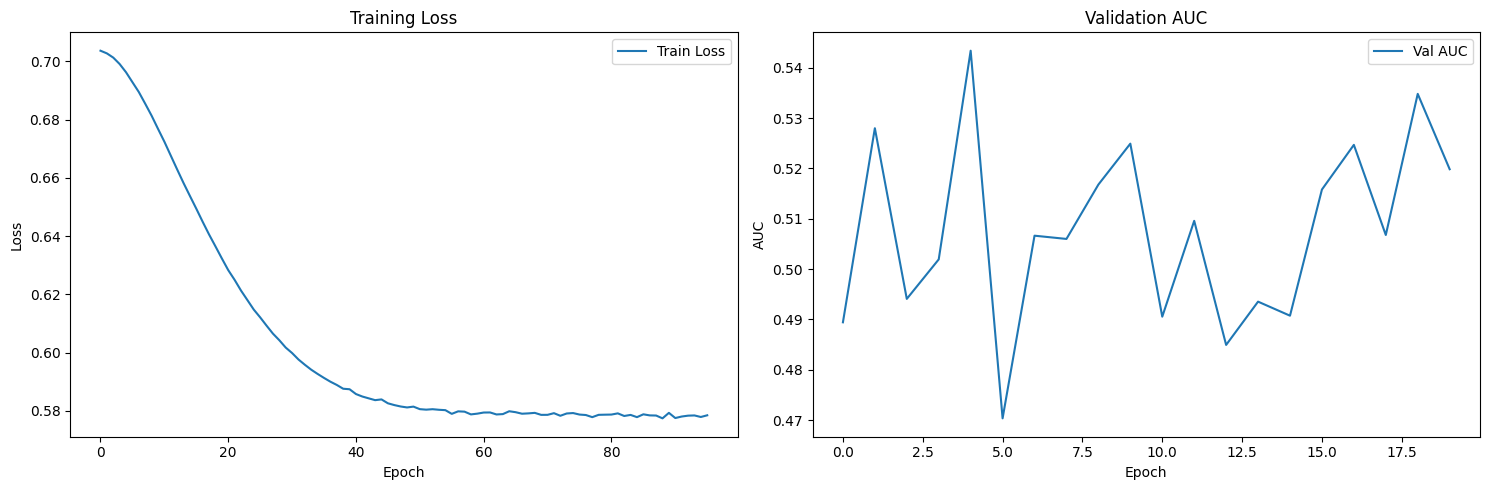

In [57]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

best_val_auc = 0
patience = 15
patience_counter = 0
train_losses = []
val_aucs = []

print('Starting training...')
for epoch in range(200):
    #training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # validation phase (every 5 epochs)
    if epoch%5 == 0:
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_auc = roc_auc_score(y_test_tensor, val_outputs.numpy())
            val_aucs.append(val_auc)

            #ealy stopping
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                patience_counter = 0
                #save the best model
                torch.save(model.state_dict(), 'best_model.pth')
                torch.save(model.state_dict, 'best_model.pth')
            else:
                patience_counter += 1

    print(f'Epoch {epoch:3d} | Train Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | best_val_auc: {best_val_auc:.4f} | patience_counter: {patience_counter}')

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break


# plotting the training progress
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_aucs, label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation AUC')
plt.legend()

plt.tight_layout()
plt.show()

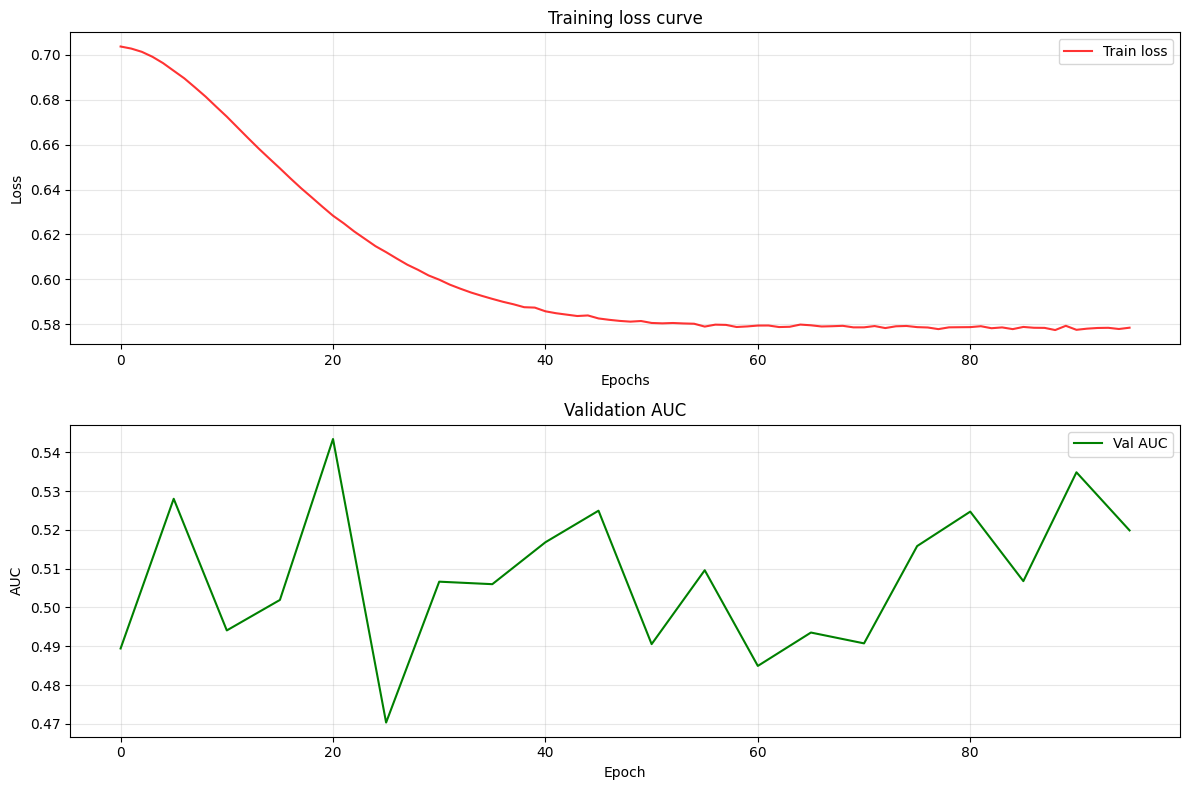

In [58]:
# Create the training and validation metrics plot
plt.figure(figsize=(12, 8))

# Main plot: Training Loss
plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Train loss', color='red', alpha=0.8)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Secondary plot: Validation AUC
plt.subplot(2, 1, 2)
val_epochs = list(range(0, len(val_aucs) * 5, 5))
plt.plot(val_epochs, val_aucs, label='Val AUC', color='green')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation AUC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()